In [1]:
import torch
import torch.nn as nn
import numpy as np
from dataloader_trun import EHRDataset
from torch.utils.data import DataLoader
from models.transformer_model1 import TransformerPredictor
from models.SWE import SWE_Pooling
from utils import create_tokenizer, compute_metrics
from tqdm import trange, tqdm
import copy
import json
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
create_tokenizer()
train_dataset = EHRDataset(mode="train",sequence_length=100,
                           truncation=[0.2,0.4,0.6,0.8,1],
                           random_seed=3)
test_dataset = EHRDataset(mode="test",sequence_length=100,
                          truncation=[0.2,0.4,0.6,0.8,1],
                          random_seed=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
from torch.utils.data import WeightedRandomSampler
targets = np.array(list(train_dataset.targets.values()))
labels_uniques, counts = np.unique(targets, return_counts=True)
class_weights = [sum(counts)/c for c in counts]
weights = [class_weights[x] for x in targets]


Processing Test Dataset: 100%|██████████| 6480/6480 [00:01<00:00, 5720.37it/s]


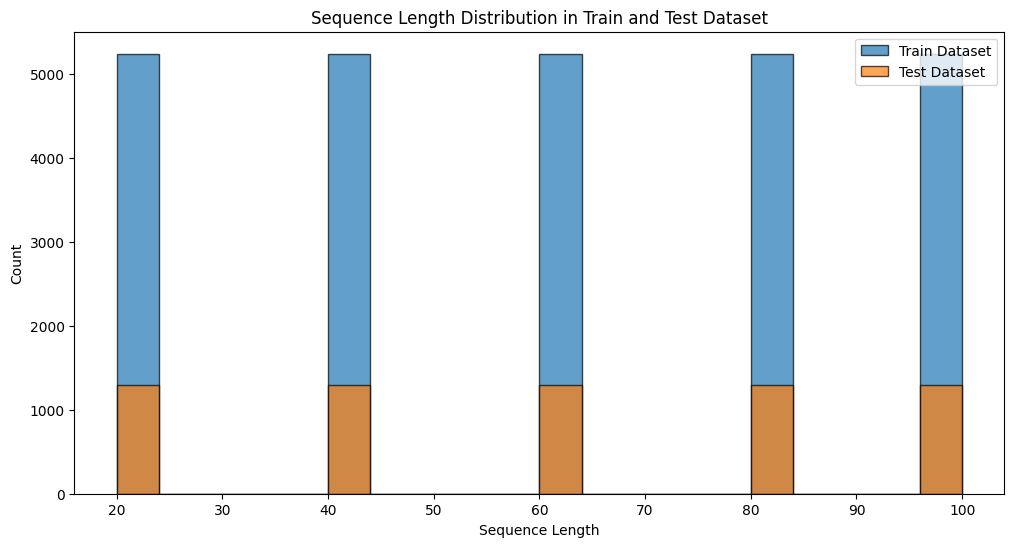

In [3]:
import matplotlib.pyplot as plt
train_lengths = []
test_lengths = []
for sample in tqdm(train_dataset, desc="Processing Train Dataset"):
    train_lengths.append(sample['seq_l'])
for sample in tqdm(test_dataset, desc="Processing Test Dataset"):
    test_lengths.append(sample['seq_l'])
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=20, alpha=0.7, label='Train Dataset', edgecolor='black')
plt.hist(test_lengths, bins=20, alpha=0.7, label='Test Dataset', edgecolor='black')
plt.title("Sequence Length Distribution in Train and Test Dataset")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.legend()
plt.show()


In [4]:
from torch.utils.data import WeightedRandomSampler
targets = 1-np.array([i["target"] for i in train_dataset])
labels_uniques, counts = np.unique(targets, return_counts=True)
class_weights = [sum(counts)/c for c in counts]
weights = [class_weights[x] for x in targets]


In [5]:
import numpy as np
targets = 1 - np.array([sample["target"] for sample in train_dataset])
ratios = np.array([sample["seq_l"] for sample in train_dataset])
unique_ratios = np.unique(ratios)
print("各个截断比例下各标签的分布：")
for r in unique_ratios:
    idx = np.where(ratios == r)[0]
    ratio_targets = targets[idx]
    unique_labels, counts = np.unique(ratio_targets, return_counts=True)
    total = len(ratio_targets)
    print(f"\n截断比例 {r}: (总样本数: {total})")
    for label, count in zip(unique_labels, counts):
        percentage = count / total * 100
        print(f"    Label {label}: {count} 个样本，占 {percentage:.2f}%")


各个截断比例下各标签的分布：

截断比例 20: (总样本数: 5238)
    Label 0: 428 个样本，占 8.17%
    Label 1: 4810 个样本，占 91.83%

截断比例 40: (总样本数: 5238)
    Label 0: 428 个样本，占 8.17%
    Label 1: 4810 个样本，占 91.83%

截断比例 60: (总样本数: 5238)
    Label 0: 428 个样本，占 8.17%
    Label 1: 4810 个样本，占 91.83%

截断比例 80: (总样本数: 5238)
    Label 0: 428 个样本，占 8.17%
    Label 1: 4810 个样本，占 91.83%

截断比例 100: (总样本数: 5238)
    Label 0: 428 个样本，占 8.17%
    Label 1: 4810 个样本，占 91.83%


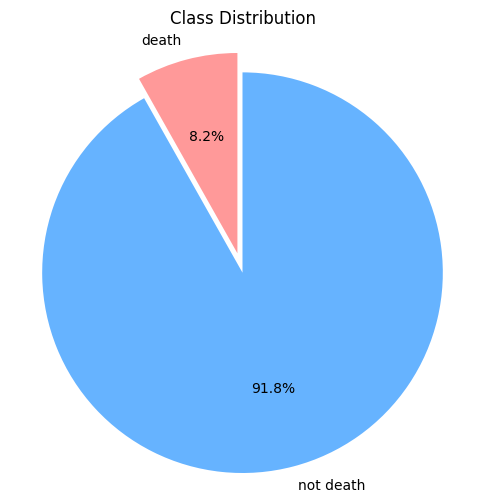

In [6]:
import matplotlib.pyplot as plt
labels = ['death', 'not death']
colors = ['
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.1, 0))
plt.title('Class Distribution')
plt.axis('equal')
plt.show()


In [125]:
def model_train(
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    d_embed=96,
    d_transformer=256,
    start_lr=1e-4,
    end_lr=1e-5,
    n_layer=2,
    dropout=0.5,
    weight_decay=1e-4,
    epochs=100,
    patience=10,
    num_slices=256,
    num_ref_points=10,
    seq_l=100,
    pooling="cls"
):
    sampler = WeightedRandomSampler(weights, len(targets))
    criterion = nn.BCELoss().to(device)
    train_dataset = EHRDataset(mode="train",sequence_length=seq_l)
    test_dataset = EHRDataset(mode="test",sequence_length=seq_l)
    if pooling == "swe":
        swe_pooling_layer= SWE_Pooling(d_in=d_transformer, num_slices=num_slices, num_ref_points=num_ref_points, freeze_swe=False).to(device)
    else:
        swe_pooling_layer=None
    model = TransformerPredictor(
        d_embedding=d_embed,
        d_model=d_transformer,
        n_layers=n_layer,
        swe_pooling=swe_pooling_layer,
        tokenizer_codes=train_dataset.tokenizer,
        dropout=dropout,
        device=device,
        pooling=pooling
    ).to(device)
    if pooling == "swe":
        optimizer = torch.optim.Adam(
            list(model.swe_pooling.parameters()) + list(model.cls.parameters()) + list(model.transformer.parameters()),
            lr=1,
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=1,
        )
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda epoch: start_lr * (1 - epoch / epochs) + end_lr * (epoch / epochs)
    )
    best_test_auprc = 0.
    current_patience = 0
    for epoch in range(epochs):
        model.train()
        y_prob, y_true = [], []
        for e in DataLoader(dataset=train_dataset, batch_size=512, drop_last=False, sampler=sampler):
            optimizer.zero_grad()
            attention_mask=e["attention_mask"].to(device)
            minutes, codes, values = e['minutes'].to(device), e['codes'].to(device), e['values'].to(device)
            y = e['target'].to(device)
            output = model(codes, values, minutes,attention_mask)
            loss = criterion(output.squeeze(), y.float())
            loss.backward()
            optimizer.step()
            y_prob += output.squeeze().detach().cpu().tolist()
            y_true += y.cpu().tolist()
        acc, auprc, auroc, bce = compute_metrics(y_true, y_prob)
        print(f"Epoch {epoch + 1}: train: acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}")
        scheduler.step()
        model.eval()
        y_prob, y_true = [], []
        for e in DataLoader(dataset=test_dataset, batch_size=512, shuffle=False, drop_last=False):
            minutes, codes, values = e['minutes'].to(device), e['codes'].to(device), e['values'].to(device)
            y = e['target'].to(device)
            attention_mask=e["attention_mask"].to(device)
            output = model(codes, values, minutes, attention_mask)
            y_prob += output.squeeze().detach().cpu().tolist()
            y_true += y.cpu().tolist()
        acc, auprc, auroc, bce = compute_metrics(y_true, y_prob)
        print(f" Test: acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}")
        if auprc > best_test_auprc:
            current_patience = 0
            best_test_auprc = auprc
            best_dict = copy.deepcopy(model.state_dict())
            best_row = f" best test (epoch {epoch}): acc {round(acc, 3)}; auprc {round(auprc, 3)}; auroc {round(auroc, 3)}; bce {round(bce, 3)}"
        else:
            current_patience += 1
        tqdm.write(best_row)
        if current_patience >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break


In [126]:
def ensemble_model_train(
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    d_embed=96,
    d_transformer=256,
    start_lr=1e-4,
    end_lr=1e-5,
    n_layer=2,
    dropout=0.5,
    weight_decay=1e-4,
    epochs=100,
    patience=10,
    num_slices=256,
    num_ref_points=10,
    seq_l=500,
    pooling="cls",
    n_trainings=1,
    batch_size=512,
    save_dir='model_ensemble_preds'
):
    sampler = WeightedRandomSampler(weights, len(targets),replacement=True)
    criterion = nn.BCELoss().to(device)
    n_test_samples = len(test_dataset)
    predictions_df = pd.DataFrame(index=range(n_test_samples), columns=range(n_trainings))
    print(f"\nTraining {n_trainings} models for the ensemble...")
    for i in range(n_trainings):
        print(f"\n=== Ensemble Model {i+1}/{n_trainings} ===")
        if pooling == "swe":
            swe_pooling_layer = SWE_Pooling(
                d_in=d_transformer,
                num_slices=num_slices,
                num_ref_points=num_ref_points,
                freeze_swe=False
            ).to(device)
        else:
            swe_pooling_layer = None
        model = TransformerPredictor(
            d_embedding=d_embed,
            d_model=d_transformer,
            n_layers=n_layer,
            swe_pooling=swe_pooling_layer,
            tokenizer_codes=train_dataset.tokenizer,
            dropout=dropout,
            device=device,
            pooling=pooling
        ).to(device)
        if pooling == "swe":
            optimizer = torch.optim.Adam(
                list(model.swe_pooling.parameters()) +
                list(model.cls.parameters()) +
                list(model.transformer.parameters()),
                lr=1,
            )
        else:
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=1,
            )
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                                      lr_lambda=lambda epoch: start_lr*(1-epoch/epochs) + end_lr*(epoch/epochs))
        best_test_auprc = 0.0
        current_patience = 0
        best_model_dict = None
        best_info = ""
        for epoch in range(epochs):
            model.train()
            y_prob_train, y_true_train = [], []
            dataloader_train = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                drop_last=False,
                sampler=sampler
            )
            for e in dataloader_train:
                optimizer.zero_grad()
                attention_mask = e["attention_mask"].to(device)
                minutes = e["minutes"].to(device)
                codes = e["codes"].to(device)
                values = e["values"].to(device)
                y = e["target"].to(device)
                output = model(codes, values, minutes, attention_mask)
                loss = criterion(output.squeeze(), y.float())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()
                y_prob_train += output.squeeze().detach().cpu().tolist()
                y_true_train += y.cpu().tolist()
            acc, auprc, auroc, bce = compute_metrics(y_true_train, y_prob_train)
            print(f"Epoch {epoch + 1}: train metrics -> "
                  f"acc {round(acc, 3)}, auprc {round(auprc, 3)}, auroc {round(auroc, 3)}, bce {round(bce, 3)}")
            scheduler.step()
            model.eval()
            y_prob_test, y_true_test = [], []
            dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
            with torch.no_grad():
                for e in dataloader_test:
                    attention_mask = e["attention_mask"].to(device)
                    minutes = e["minutes"].to(device)
                    codes = e["codes"].to(device)
                    values = e["values"].to(device)
                    y = e["target"].to(device)
                    output = model(codes, values, minutes, attention_mask)
                    y_prob_test += output.squeeze().detach().cpu().tolist()
                    y_true_test += y.cpu().tolist()
            acc_test, auprc_test, auroc_test, bce_test = compute_metrics(y_true_test, y_prob_test)
            if auprc_test > best_test_auprc:
                current_patience = 0
                best_test_auprc = auprc_test
                best_model_dict = copy.deepcopy(model.state_dict())
                best_info = (f"Best so far at epoch {epoch+1} | "
                             f"acc {round(acc_test, 3)}, auprc {round(auprc_test, 3)}, "
                             f"auroc {round(auroc_test, 3)}, bce {round(bce_test, 3)}")
            else:
                current_patience += 1
            print(f"         {best_info}")
            if current_patience >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        if best_model_dict is not None:
            model.load_state_dict(best_model_dict)
        model.eval()
        y_prob_test = []
        dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        with torch.no_grad():
            for e in dataloader_test:
                attention_mask = e["attention_mask"].to(device)
                minutes = e["minutes"].to(device)
                codes = e["codes"].to(device)
                values = e["values"].to(device)
                output = model(codes, values, minutes, attention_mask)
                y_prob_test.extend(output.squeeze().detach().cpu().tolist())
        predictions_df[i] = y_prob_test
    save_path = os.path.join(save_dir, f"ensemble_{pooling}_sql{seq_l}_bal.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(predictions_df, f)
    print(f"\nEnsemble predictions saved to {save_path}")
    print(f"Shape of predictions_df: {predictions_df.shape}")
    print(f"Sample predictions:\n{predictions_df.head()}")
    return predictions_df


建模整体逻辑是：

1. 定义采样器 
2. 定义损失函数 nn.CEloss().to_device()
3. 定义优化器 bb.optim.Adam(参数，学习率，衰减)
4. 学习率调度器
5. 定义每个epoch 的训练\
   - 设置模式
   - dataloader（）
   - 
   

In [7]:
import os
import copy
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import pandas as pd
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
def ensemble_model_train(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    d_embed=96,
    d_transformer=256,
    start_lr=1e-4,
    end_lr=1e-5,
    n_layer=2,
    dropout=0.5,
    weight_decay=1e-6,
    epochs=100,
    patience=10,
    num_slices=256,
    num_ref_points=10,
    seq_l=500,
    pooling="cls",
    n_trainings=1,
    batch_size=512,
    save_dir='model_ensemble_preds',
    seed: int = 5
):
    set_seed(seed)
    sampler_generator = torch.Generator()
    sampler_generator.manual_seed(seed)
    sampler = WeightedRandomSampler(
        weights,
        len(targets),
        replacement=True,
        generator=sampler_generator
    )
    criterion = nn.BCEWithLogitsLoss().to(device)
    n_test_samples = len(test_dataset)
    predictions_df = pd.DataFrame(index=range(n_test_samples), columns=range(n_trainings))
    print(f"\nTraining {n_trainings} models for the ensemble...")
    for i in range(n_trainings):
        set_seed(i+1)
        print(f"\n=== Ensemble Model {i+1}/{n_trainings} ===")
        if pooling == "swe":
            swe_pooling_layer = SWE_Pooling(
                d_in=d_transformer,
                num_slices=num_slices,
                num_ref_points=num_ref_points,
                freeze_swe=False
            ).to(device)
        else:
            swe_pooling_layer = None
        model = TransformerPredictor(
            d_embedding=d_embed,
            d_model=d_transformer,
            n_layers=n_layer,
            swe_pooling=swe_pooling_layer,
            tokenizer_codes=train_dataset.tokenizer,
            dropout=dropout,
            device=device,
            pooling=pooling
        ).to(device)
        if pooling == "swe":
            optimizer = torch.optim.Adam(
                list(model.swe_pooling.parameters()) +
                list(model.cls.parameters()) +
                list(model.transformer.parameters()),
                lr=1,
                weight_decay=weight_decay,
            )
        else:
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=weight_decay, eps=1e-8)
        def lr_lambda(epoch):
            return (start_lr * (1 - epoch / epochs) + end_lr * (epoch / epochs)) / start_lr
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
        best_test_auprc = 0.0
        current_patience = 0
        best_model_dict = None
        best_info = ""
        for epoch in range(1,epochs):
            model.train()
            y_prob_train, y_true_train = [], []
            dataloader_train = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                drop_last=False,
                sampler=sampler
            )
            for batch_idx, e in enumerate(dataloader_train):
                optimizer.zero_grad()
                attention_mask = e["attention_mask"].to(device)
                minutes = e["minutes"].to(device)
                codes = e["codes"].to(device)
                values = e["values"].to(device)
                y = e["target"].to(device)
                output = model(codes, values, minutes, attention_mask)
                if torch.isnan(output).any() or torch.isinf(output).any():
                    print(f"\n[ERROR] 发现 NaN 或 Inf！")
                    print(f"Batch: {batch_idx} | Epoch: {epoch + 1}")
                    print(f"输出范围：min={output.min().item()}, max={output.max().item()}\n")
                    print("\n==== 当前 batch 输入数据 ====")
                    print("attention_mask:", e["attention_mask"])
                    print("minutes:", e["minutes"])
                    print("codes:", e["codes"])
                    print("values:", e["values"])
                    print("target:", e["target"])
                loss = criterion(output.squeeze(), y.float())
                if torch.isnan(loss) or torch.isinf(loss):
                    print("\n[ERROR] Loss 计算异常！")
                    print(f"Batch: {batch_idx} | Epoch: {epoch + 1}")
                    print(f"Loss 值: {loss.item()}\n")
                    exit()
                loss.backward()
                g=True
                for name, param in model.named_parameters():
                    if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                        print(f"\n[ERROR] 反向传播后梯度 NaN ！{name}")
                        print(f"  grad min: {param.grad.min().item()}, grad max: {param.grad.max().item()}\n")
                        print(f"loss:{loss.item()}\n")
                        g=False
                        break
                        print("\n==== 当前 batch 输入数据 ====")
                        print("attention_mask:", e["attention_mask"])
                        print("minutes:", e["minutes"])
                        print("codes:", e["codes"])
                        print("values:", e["values"])
                        print("target:", e["target"])
                if not g:
                    break
                optimizer.step()
                y_prob_train.extend(torch.sigmoid(output).squeeze().detach().cpu().tolist())
                y_true_train.extend(y.cpu().tolist())
            acc, auprc, auroc, bce = compute_metrics(y_true_train, y_prob_train)
            print(f"Epoch {epoch + 1}: train metrics -> "
                  f"acc {round(acc, 3)}, auprc {round(auprc, 3)}, auroc {round(auroc, 3)}, bce {round(bce, 3)}")
            scheduler.step()
            model.eval()
            y_prob_test, y_true_test = [], []
            dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
            with torch.no_grad():
                for e in dataloader_test:
                    attention_mask = e["attention_mask"].to(device)
                    minutes = e["minutes"].to(device)
                    codes = e["codes"].to(device)
                    values = e["values"].to(device)
                    y = e["target"].to(device)
                    output = model(codes, values, minutes, attention_mask)
                    y_prob_test += torch.sigmoid(output).squeeze().detach().cpu().tolist()
                    y_true_test += y.cpu().tolist()
            acc_test, auprc_test, auroc_test, bce_test = compute_metrics(y_true_test, y_prob_test)
            if auprc_test > best_test_auprc:
                current_patience = 0
                best_test_auprc = auprc_test
                best_model_dict = copy.deepcopy(model.state_dict())
                best_info = (
                    f"Best so far at epoch {epoch+1} | "
                    f"acc {round(acc_test, 3)}, auprc {round(auprc_test, 3)}, "
                    f"auroc {round(auroc_test, 3)}, bce {round(bce_test, 3)}"
                )
            else:
                current_patience += 1
            print(f"         {best_info}")
            if current_patience >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        if best_model_dict is not None:
            model.load_state_dict(best_model_dict)
        model.eval()
        y_prob_test = []
        dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        with torch.no_grad():
            for e in dataloader_test:
                attention_mask = e["attention_mask"].to(device)
                minutes = e["minutes"].to(device)
                codes = e["codes"].to(device)
                values = e["values"].to(device)
                output = model(codes, values, minutes, attention_mask)
                y_prob_test.extend(torch.sigmoid(output).squeeze().detach().cpu().tolist())
        predictions_df[i] = y_prob_test
        result11.append(y_prob_test)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"ensemble_{pooling}_sql{seq_l}_trun.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(predictions_df, f)
    print(f"\nEnsemble predictions saved to {save_path}")
    print(f"Shape of predictions_df: {predictions_df.shape}")
    print(f"Sample predictions:\n{predictions_df.head()}")
    return predictions_df


In [8]:
result11=[]


In [ ]:
import pandas as pd
import os
import pickle
poolings=["cls","mean_without_padding"]
seqls=[100]
for seql in seqls:
    for pooling in poolings:
        print(pooling)
        print(seql)
        ensemble_model_train(seq_l=seql,
                             n_trainings=10,
                             device='cuda',
                             d_embed=128,
                             d_transformer=256,
                             start_lr=1e-4,
                             end_lr=1e-5,
                             n_layer=4,
                             dropout=0.2,
                             weight_decay=1e-6,
                             epochs=100,
                             patience=20,
                             num_slices=256,
                             num_ref_points=10,
                             pooling=pooling,
                             batch_size=16,
                             save_dir='model_result')


cls
100

Training 10 models for the ensemble...

=== Ensemble Model 1/10 ===
Epoch 2: train metrics -> acc 52.165, auprc 0.522, auroc 0.53, bce 0.695
         Best so far at epoch 2 | acc 20.679, auprc 0.119, auroc 0.592, bce 0.895
Epoch 3: train metrics -> acc 60.504, auprc 0.619, auroc 0.647, bce 0.657
         Best so far at epoch 3 | acc 75.062, auprc 0.193, auroc 0.745, bce 0.447
Epoch 4: train metrics -> acc 70.221, auprc 0.74, auroc 0.772, bce 0.567
         Best so far at epoch 4 | acc 79.815, auprc 0.269, auroc 0.772, bce 0.435
Epoch 5: train metrics -> acc 73.501, auprc 0.771, auroc 0.807, bce 0.529
         Best so far at epoch 4 | acc 79.815, auprc 0.269, auroc 0.772, bce 0.435
Epoch 6: train metrics -> acc 75.323, auprc 0.796, auroc 0.83, bce 0.5
         Best so far at epoch 4 | acc 79.815, auprc 0.269, auroc 0.772, bce 0.435
Epoch 7: train metrics -> acc 77.423, auprc 0.82, auroc 0.849, bce 0.473
         Best so far at epoch 7 | acc 83.349, auprc 0.273, auroc 0.772, bce

In [13]:
import pickle
poolings = ["cls","mean_without_padding"]
truncations = ["100"]
seq_l=100
res_set = []
for pooling in poolings:
    try:
        with open(f'model_result/ensemble_{pooling}_sql{seq_l}_trun.pkl', 'rb') as f:
            sub_res = pickle.load(f)
    except FileNotFoundError:
        print(f"File model_ensemble_preds/ensemble_{pooling}_sql{seq_l}.pkl not found. Skipping.")
        continue
    res_set.append(sub_res)


In [14]:
from sklearn.calibration import calibration_curve


In [15]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
                             brier_score_loss)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
def compute_ece(y_true, y_prob, n_bins=10):
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bin_edges[i]
        bin_upper = bin_edges[i + 1]
        bin_mask = (y_prob > bin_lower) & (y_prob <= bin_upper)
        bin_count = np.sum(bin_mask)
        if bin_count > 0:
            bin_accuracy = np.mean(y_true[bin_mask] == 1)
            bin_confidence = np.mean(y_prob[bin_mask])
            ece += np.abs(bin_accuracy - bin_confidence) * (bin_count / len(y_true))
    return ece
def uncertainty_auroc(y, predictions, variance):
    y = np.array(y)
    predictions = np.array(predictions)
    variance = np.array(variance)
    correctness = (y == (predictions > 0.5))
    fprs, tprs, _ = roc_curve(correctness, -1 * variance)
    auc = roc_auc_score(correctness, -1 * variance)
    return tprs, fprs, auc
def calculate_ause(uncertainty, predictions, targets, metric='brier',
                   uncertainty_type='variance', bins=10, save_path=None, min_fraction=0.0,
                   max_fraction=0.9, ax=None, color='b', label='Sparsification Error'):
    if not (len(predictions) == len(targets) == len(uncertainty)):
        raise ValueError("predictions, targets, and uncertainty must have the same length.")
    if len(predictions) < 10:
        raise ValueError("Not enough predictions for sparsification.")
    def brier_score(preds, tgts):
        return np.mean((preds - tgts)**2)
    def mean_absolute_error(preds, tgts):
        return np.mean(np.abs(preds - tgts))
    def calculate_ece_metric(preds, tgts, n_bins=10):
        n = len(preds)
        if n == 0:
            return np.nan
        bin_edges = np.linspace(0., 1., n_bins + 1)
        bin_indices = np.digitize(preds, bin_edges, right=True) - 1
        ece = 0.0
        for i in range(n_bins):
            bin_mask = bin_indices == i
            bin_size = np.sum(bin_mask)
            if bin_size > 0:
                bin_confidence = np.mean(preds[bin_mask])
                bin_accuracy = np.mean(tgts[bin_mask])
                ece += (bin_size / n) * np.abs(bin_accuracy - bin_confidence)
        return ece
    def calculate_auc_metric(preds, tgts):
        if len(np.unique(tgts)) < 2:
            return np.nan
        return roc_auc_score(tgts, preds)
    if metric == 'brier':
        error_function = brier_score
    elif metric == 'mae':
        error_function = mean_absolute_error
    elif metric == 'ece':
        error_function = lambda p, t: calculate_ece_metric(p, t, n_bins=bins)
    elif metric == 'auc':
        error_function = calculate_auc_metric
    else:
        raise ValueError("Unknown metric. Choose from 'brier', 'mae', 'ece', or 'auc'.")
    sorted_inds_uncertainty = np.argsort(uncertainty)
    if metric in ['brier', 'mae']:
        if metric == 'brier':
            true_errors = (predictions - targets)**2
        else:
            true_errors = np.abs(predictions - targets)
        sorted_inds_error = np.argsort(true_errors)
    else:
        sorted_inds_error = None
    uncertainty_scores = []
    oracle_scores = []
    fractions = np.linspace(min_fraction, max_fraction, int((max_fraction - min_fraction)/0.01) + 1)
    num_samples = len(predictions)
    for fraction in fractions:
        num_keep = max(1, int((1.0 - fraction) * num_samples))
        inds_keep_uncertainty = sorted_inds_uncertainty[:num_keep]
        remaining_preds = predictions[inds_keep_uncertainty]
        remaining_targets = targets[inds_keep_uncertainty]
        try:
            uncertainty_error_score = error_function(remaining_preds, remaining_targets)
        except ValueError as e:
            print(f"Error calculating {metric} at fraction {fraction:.2f}: {e}")
            uncertainty_error_score = np.nan
        uncertainty_scores.append(uncertainty_error_score)
        if sorted_inds_error is not None:
            inds_keep_oracle = sorted_inds_error[:num_keep]
            oracle_preds = predictions[inds_keep_oracle]
            oracle_targets = targets[inds_keep_oracle]
            try:
                oracle_error_score = error_function(oracle_preds, oracle_targets)
            except ValueError as e:
                print(f"Error calculating Oracle {metric} at fraction {fraction:.2f}: {e}")
                oracle_error_score = np.nan
            oracle_scores.append(oracle_error_score)
        else:
            oracle_scores.append(np.nan)
    uncertainty_scores = np.array(uncertainty_scores)
    oracle_scores = np.array(oracle_scores)
    if metric in ['brier', 'mae']:
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        if sorted_inds_error is not None:
            oracle_scores_normalized = oracle_scores / oracle_scores[0]
        else:
            oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'ece':
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'auc':
        uncertainty_scores_normalized = (1 - uncertainty_scores) / (1 - uncertainty_scores[0])
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    else:
        raise ValueError("Unknown metric.")
    ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    if metric in ['brier', 'mae', 'ece', 'auc']:
        ax.plot(fractions, uncertainty_scores_normalized, label=f"{label} (AUSE={ause_pred:.4f})", color=color)
    ax.set_xlabel("Fraction of removed samples")
    ax.set_ylabel(f"{metric.upper()} Error (Normalized)")
    ax.set_ylim([0, 1.5])
    ax.set_title('Sparsification Curve')
    ax.legend()
    ax.grid(True)
    if save_path:
        plt.savefig(save_path)
    elif ax is None:
        plt.show()
    return ause_pred


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.calibration import calibration_curve
from scipy.stats import norm
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
def compute_ece(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    ece = np.abs(prob_true - prob_pred).mean()
    return ece
def shannon_entropy(p, epsilon=1e-10):
    p = np.clip(p, epsilon, 1 - epsilon)
    entropy = -p * np.log(p) - (1 - p) * np.log(1 - p)
    return entropy
def model_result_show(prob_df_set, y, n, df_names, truncation_labels, truncation_colors, metric='brier'):
    y = np.array(y).ravel()
    num_poolings = len(prob_df_set)
    num_truncations = len(truncation_labels)
    fig, axes = plt.subplots(num_poolings, 10, figsize=(60, 6 * num_poolings))
    if num_poolings == 1:
        axes = np.array([axes])
    metrics_records = []
    colors = truncation_colors
    for i in range(num_poolings):
        pooling_name = df_names[i]
        ax_var_density        = axes[i][0]
        ax_unc_roc           = axes[i][1]
        ax_calibration       = axes[i][2]
        ax_normal_roc        = axes[i][3]
        ax_sparsification    = axes[i][4]
        ax_brier_density     = axes[i][5]
        ax_entropy_density   = axes[i][6]
        ax_nll_density       = axes[i][7]
        ax_pred_prob_density = axes[i][8]
        ax_pr                = axes[i][9]
        for t_idx in range(num_truncations):
            df = prob_df_set[i][t_idx]
            df = np.array(df)
            trunc_name = truncation_labels[t_idx]
            predictions = np.mean(df, axis=1)
            variance = np.var(df, axis=1)
            std_dev = np.sqrt(variance)
            normal_fpr, normal_tpr, _ = roc_curve(y, predictions)
            normal_auc = roc_auc_score(y, predictions)
            unc_tpr, unc_fpr, unc_auc = uncertainty_auroc(y, predictions, variance)
            prob_true, prob_pred = calibration_curve(y, predictions, n_bins=10)
            ece_score = compute_ece(y, predictions)
            auprc = average_precision_score(y, predictions)
            brier = (y - predictions) ** 2
            epsilon = 1e-10
            nll = - y * np.log(predictions + epsilon) - (1 - y) * np.log(1 - predictions + epsilon)
            entropy_pred = shannon_entropy(predictions)
            residuals = y - predictions
            residual_var = residuals ** 2
            pred_prob_mean = np.mean(predictions)
            c = colors[t_idx]
            variance_1 = np.round(np.mean(variance), 5)
            sns.kdeplot(
                variance,
                ax=ax_var_density,
                label=f"{trunc_name} (avg_Var={variance_1})",
                fill=False,
                color=c
            )
            ax_unc_roc.plot(
                unc_fpr,
                unc_tpr,
                label=f"{trunc_name} (AUROC={unc_auc:.2f})",
                color=c
            )
            ax_calibration.plot(
                prob_pred,
                prob_true,
                marker="o",
                label=f"{trunc_name} (ECE={ece_score:.2f})",
                color=c
            )
            ax_normal_roc.plot(
                normal_fpr,
                normal_tpr,
                label=f"{trunc_name} (AUC={normal_auc:.2f})",
                color=c
            )
            ause = calculate_ause(
                uncertainty=variance,
                predictions=predictions,
                targets=y,
                metric=metric,
                min_fraction=0.0,
                max_fraction=0.9,
                ax=ax_sparsification,
                color=c,
                label=f"{trunc_name}"
            )
            sns.kdeplot(
                brier,
                ax=ax_brier_density,
                label=f"{trunc_name} (Mean Brier={np.mean(brier):.4f})",
                color=c
            )
            sns.kdeplot(
                entropy_pred,
                ax=ax_entropy_density,
                label=f"{trunc_name} (Mean Entropy={np.mean(entropy_pred):.4f})",
                color=c
            )
            sns.kdeplot(
                nll,
                ax=ax_nll_density,
                label=f"{trunc_name} (Mean NLL={np.mean(nll):.4f})",
                color=c
            )
            sns.kdeplot(
                predictions,
                ax=ax_pred_prob_density,
                label=f"{trunc_name} (Mean Pred={pred_prob_mean:.4f})",
                color=c
            )
            precision, recall, thresholds  = precision_recall_curve(y, predictions)
            auprc = average_precision_score(y, predictions)
            ax_pr.plot(
                recall,
                precision,
                marker='.',
                label=f"{trunc_name} (AUPRC={auprc:.2f})",
                color=c
            )
            ax_pr.set_xlim([0.0, 1.0])
            ax_pr.set_ylim([0.0, 1.05])
            ax_pr.set_xlabel('Recall')
            ax_pr.set_ylabel('Precision')
            ax_pr.set_title('Precision-Recall Curve')
            ax_pr.legend()
            ax_pr.grid(True)
            metrics_records.append({
                "pooling": pooling_name,
                "truncation": trunc_name,
                "normal_auc": normal_auc,
                "uncertainty_auc": unc_auc,
                "auprc": auprc,
                "ece": ece_score,
                "brier_score_mean": np.mean(brier),
                "entropy_mean": np.mean(entropy_pred),
                "nll_mean": np.mean(nll),
                "pred_prob_mean": pred_prob_mean,
                "ause": ause,
                "var": np.mean(variance)
            })
        ax_var_density.set_title(f"{pooling_name} Variance Density")
        ax_var_density.set_xlabel("Variance")
        ax_var_density.legend()
        ax_unc_roc.set_title(f"{pooling_name} Uncertainty ROC")
        ax_unc_roc.set_xlabel("False Positive Rate")
        ax_unc_roc.set_ylabel("True Positive Rate")
        ax_unc_roc.plot([0, 1], [0, 1], '--', color='gray')
        ax_unc_roc.legend()
        ax_unc_roc.grid(True)
        ax_calibration.set_title(f"{pooling_name} Calibration Curve")
        ax_calibration.set_xlabel("Mean Predicted Probability")
        ax_calibration.set_ylabel("Actual Positive Proportion")
        ax_calibration.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax_calibration.legend()
        ax_normal_roc.set_title(f"{pooling_name} ROC Curve")
        ax_normal_roc.set_xlabel("False Positive Rate")
        ax_normal_roc.set_ylabel("True Positive Rate")
        ax_normal_roc.plot([0, 1], [0, 1], '--', color="gray")
        ax_normal_roc.legend()
        ax_normal_roc.grid(True)
        ax_sparsification.set_title(f"{pooling_name} Sparsification Curve (Metric: {metric.upper()})")
        ax_sparsification.set_ylim([-0.01, 1.05])
        ax_sparsification.legend()
        ax_sparsification.grid(True)
        ax_brier_density.set_title(f"{pooling_name} Brier Score Density Plot")
        ax_brier_density.set_xlabel("Brier Score")
        ax_brier_density.set_ylabel("Density")
        ax_brier_density.legend()
        ax_entropy_density.set_title(f"{pooling_name} Prediction Distribution Entropy Density Plot")
        ax_entropy_density.set_xlabel("Entropy")
        ax_entropy_density.set_ylabel("Density")
        ax_entropy_density.legend()
        ax_nll_density.set_title(f"{pooling_name} Negative Log-Likelihood (NLL) Density Plot")
        ax_nll_density.set_xlabel("NLL")
        ax_nll_density.set_ylabel("Density")
        ax_nll_density.legend()
        ax_pred_prob_density.set_title(f"{pooling_name} Predicted Probability Density Plot")
        ax_pred_prob_density.set_xlabel("Predicted Probability")
        ax_pred_prob_density.set_ylabel("Density")
        ax_pred_prob_density.legend()
        ax_pr.set_title(f"{pooling_name} Precision-Recall Curve")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.legend()
        ax_pr.grid(True)
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(metrics_records)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)
def model_result_show(
    prob_df_set,
    y,
    n,
    df_names,
    truncations,
    truncation_colors,
    metric='brier'
):
    y = np.array(y).ravel()
    n = np.array(n).ravel()
    num_poolings = len(prob_df_set)
    fig, axes = plt.subplots(num_poolings, 10, figsize=(60, 6 * num_poolings))
    if num_poolings == 1:
        axes = np.array([axes])
    metrics_records = []
    for i in range(num_poolings):
        pooling_name = df_names[i]
        df_full = prob_df_set[i]
        df_full = np.array(df_full)
        ax_var_density        = axes[i][0]
        ax_unc_roc           = axes[i][1]
        ax_calibration       = axes[i][2]
        ax_normal_roc        = axes[i][3]
        ax_sparsification    = axes[i][4]
        ax_brier_density     = axes[i][5]
        ax_entropy_density   = axes[i][6]
        ax_nll_density       = axes[i][7]
        ax_pred_prob_density = axes[i][8]
        ax_pr                = axes[i][9]
        for t_idx, t_val in enumerate(truncations):
            if t_idx == 0:
                mask = (n <= t_val)
            else:
                mask = (n > truncations[t_idx - 1]) & (n <= t_val)
            if not np.any(mask):
                continue
            sub_df = df_full[mask]
            sub_y  = y[mask]
            fraction_data = sub_df.shape[0] / df_full.shape[0]
            predictions = np.mean(sub_df, axis=1)
            variance = np.var(sub_df, axis=1)
            std_dev = np.sqrt(variance)
            normal_fpr, normal_tpr, _ = roc_curve(sub_y, predictions)
            normal_auc = roc_auc_score(sub_y, predictions)
            unc_tpr, unc_fpr, unc_auc = uncertainty_auroc(sub_y, predictions, variance)
            prob_true, prob_pred = calibration_curve(sub_y, predictions, n_bins=10)
            ece_score = compute_ece(sub_y, predictions)
            precision, recall, thresholds = precision_recall_curve(sub_y, predictions)
            auprc = average_precision_score(sub_y, predictions)
            brier = (sub_y - predictions) ** 2
            epsilon = 1e-10
            nll = -sub_y * np.log(predictions + epsilon) - (1 - sub_y) * np.log(1 - predictions + epsilon)
            entropy_pred = shannon_entropy(predictions)
            ause = calculate_ause(
                uncertainty=variance,
                predictions=predictions,
                targets=sub_y,
                metric=metric,
                min_fraction=0.0,
                max_fraction=0.9,
                ax=ax_sparsification,
                color=truncation_colors[t_idx],
                label=f"{t_val}"
            )
            variance_mean  = np.mean(variance)
            brier_mean     = np.mean(brier)
            entropy_mean   = np.mean(entropy_pred)
            nll_mean       = np.mean(nll)
            pred_prob_mean = np.mean(predictions)
            if t_idx == 0:
                trunc_name = f"≤ {t_val}"
            else:
                trunc_name = f"{truncations[t_idx - 1]}-{t_val}"
            c = truncation_colors[t_idx]
            sns.kdeplot(
                variance,
                ax=ax_var_density,
                label=f"{trunc_name} (avgVar={variance_mean:.5f}, ratio={fraction_data:.2f})",
                fill=False,
                color=c
            )
            ax_unc_roc.plot(
                unc_fpr,
                unc_tpr,
                label=f"{trunc_name} (AUROC={unc_auc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_calibration.plot(
                prob_pred,
                prob_true,
                marker="o",
                label=f"{trunc_name} (ECE={ece_score:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_normal_roc.plot(
                normal_fpr,
                normal_tpr,
                label=f"{trunc_name} (AUC={normal_auc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                brier,
                ax=ax_brier_density,
                label=f"{trunc_name} (MeanBrier={brier_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                entropy_pred,
                ax=ax_entropy_density,
                label=f"{trunc_name} (MeanEntropy={entropy_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                nll,
                ax=ax_nll_density,
                label=f"{trunc_name} (MeanNLL={nll_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                predictions,
                ax=ax_pred_prob_density,
                label=f"{trunc_name} (MeanPred={pred_prob_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_pr.plot(
                recall,
                precision,
                marker='.',
                label=f"{trunc_name} (AUPRC={auprc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            metrics_records.append({
                "pooling": pooling_name,
                "truncation": trunc_name,
                "ratio": fraction_data,
                "normal_auc": normal_auc,
                "uncertainty_auc": unc_auc,
                "auprc": auprc,
                "ece": ece_score,
                "brier_score_mean": brier_mean,
                "entropy_mean": entropy_mean,
                "nll_mean": nll_mean,
                "pred_prob_mean": pred_prob_mean,
                "ause": ause,
                "var_mean": variance_mean
            })
        ax_var_density.set_title(f"{pooling_name} - Variance Density")
        ax_var_density.set_xlabel("Variance")
        ax_var_density.legend()
        ax_unc_roc.set_title(f"{pooling_name} - Uncertainty ROC")
        ax_unc_roc.set_xlabel("False Positive Rate")
        ax_unc_roc.set_ylabel("True Positive Rate")
        ax_unc_roc.plot([0, 1], [0, 1], '--', color='gray')
        ax_unc_roc.legend()
        ax_unc_roc.grid(True)
        ax_calibration.set_title(f"{pooling_name} - Calibration Curve")
        ax_calibration.set_xlabel("Mean Predicted Probability")
        ax_calibration.set_ylabel("Actual Positive Proportion")
        ax_calibration.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax_calibration.legend()
        ax_normal_roc.set_title(f"{pooling_name} - ROC Curve")
        ax_normal_roc.set_xlabel("False Positive Rate")
        ax_normal_roc.set_ylabel("True Positive Rate")
        ax_normal_roc.plot([0, 1], [0, 1], '--', color="gray")
        ax_normal_roc.legend()
        ax_normal_roc.grid(True)
        ax_sparsification.set_title(f"{pooling_name} - Sparsification Curve (Metric: {metric.upper()})")
        ax_sparsification.set_ylim([-0.01, 1.05])
        ax_sparsification.legend()
        ax_sparsification.grid(True)
        ax_brier_density.set_title(f"{pooling_name} - Brier Score Density")
        ax_brier_density.set_xlabel("Brier Score")
        ax_brier_density.set_ylabel("Density")
        ax_brier_density.legend()
        ax_entropy_density.set_title(f"{pooling_name} - Prediction Dist. Entropy Density")
        ax_entropy_density.set_xlabel("Entropy")
        ax_entropy_density.set_ylabel("Density")
        ax_entropy_density.legend()
        ax_nll_density.set_title(f"{pooling_name} - Negative Log-Likelihood (NLL) Density")
        ax_nll_density.set_xlabel("NLL")
        ax_nll_density.set_ylabel("Density")
        ax_nll_density.legend()
        ax_pred_prob_density.set_title(f"{pooling_name} - Predicted Probability Density")
        ax_pred_prob_density.set_xlabel("Predicted Probability")
        ax_pred_prob_density.set_ylabel("Density")
        ax_pred_prob_density.legend()
        ax_pr.set_title(f"{pooling_name} - Precision-Recall Curve")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.legend()
        ax_pr.grid(True)
    plt.tight_layout()
    plt.show()
    metrics_df = pd.DataFrame(metrics_records)
    return metrics_df


In [20]:
y_val_int = np.array([i["target"] for i in test_dataset])


In [22]:
sql=[]
for e in test_dataset:
    sql.append((e["seq_l"]/100))


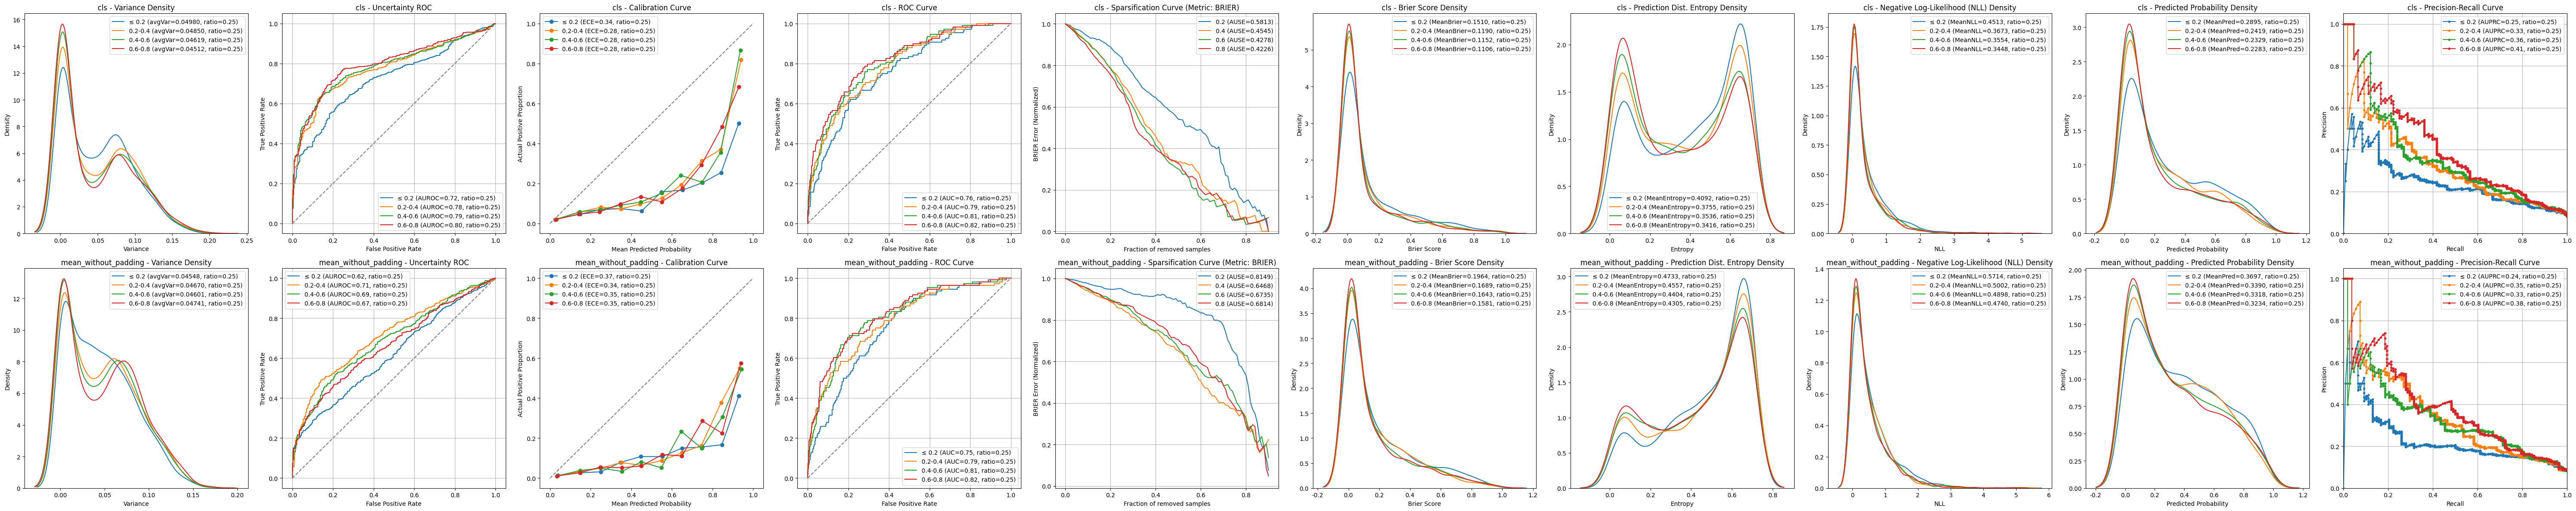

In [23]:
truncations=[0.2,0.4,0.6,0.8]
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations)+1)
data=model_result_show(
    res_set,
    y_val_int,
    sql,
    poolings,
    truncations,
    truncation_colors,
    metric='brier'
)


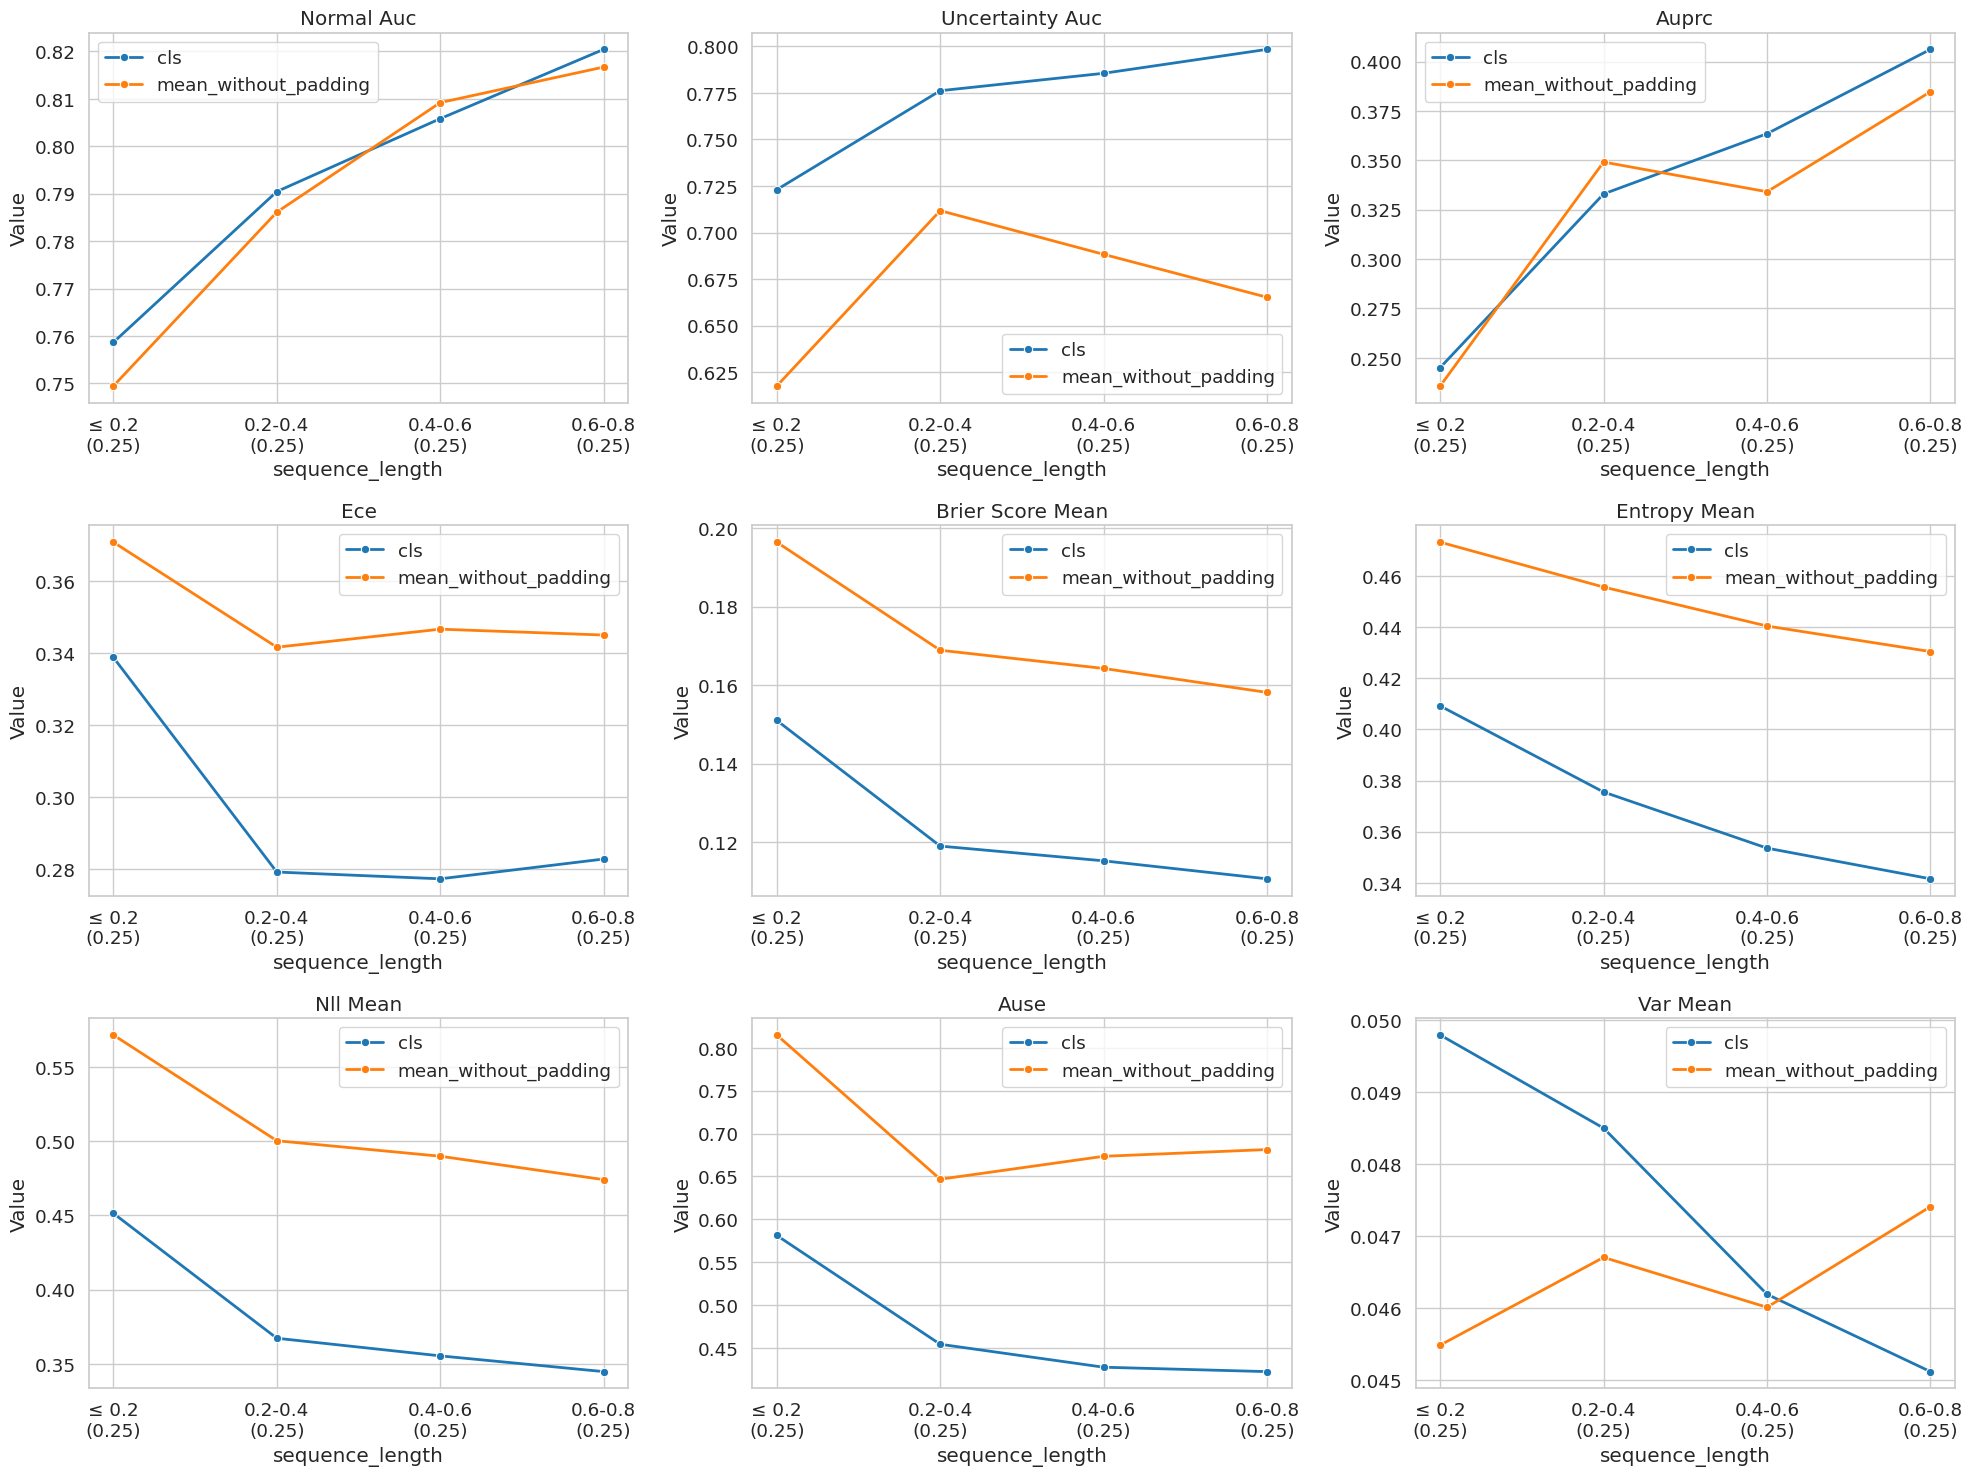

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_ratio_dict = df.groupby('truncation')['ratio'].first().to_dict()
metrics = df.columns.to_list()[3:10] + df.columns.to_list()[11:]
df_melted = df.melt(
    id_vars=['pooling', 'truncation'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(
            data=data_pooling,
            x='truncation',
            y='value',
            marker='o',
            label=pooling,
            color=color_dict[pooling],
            ax=ax,
            linewidth=2
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('sequence_length')
    ax.set_ylabel('Value')
    ax.legend()
    current_ticklabels = ax.get_xticklabels()
    new_labels = []
    for lbl in current_ticklabels:
        text = lbl.get_text()
        if text in truncation_ratio_dict:
            ratio_val = truncation_ratio_dict[text]
            new_label = f"{text}\n({ratio_val:.2f})"
        else:
            new_label = text
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
for j in range(len(unique_metrics), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


/tmp/ipykernel_706340/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_706340/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_706340/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_706340/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.i

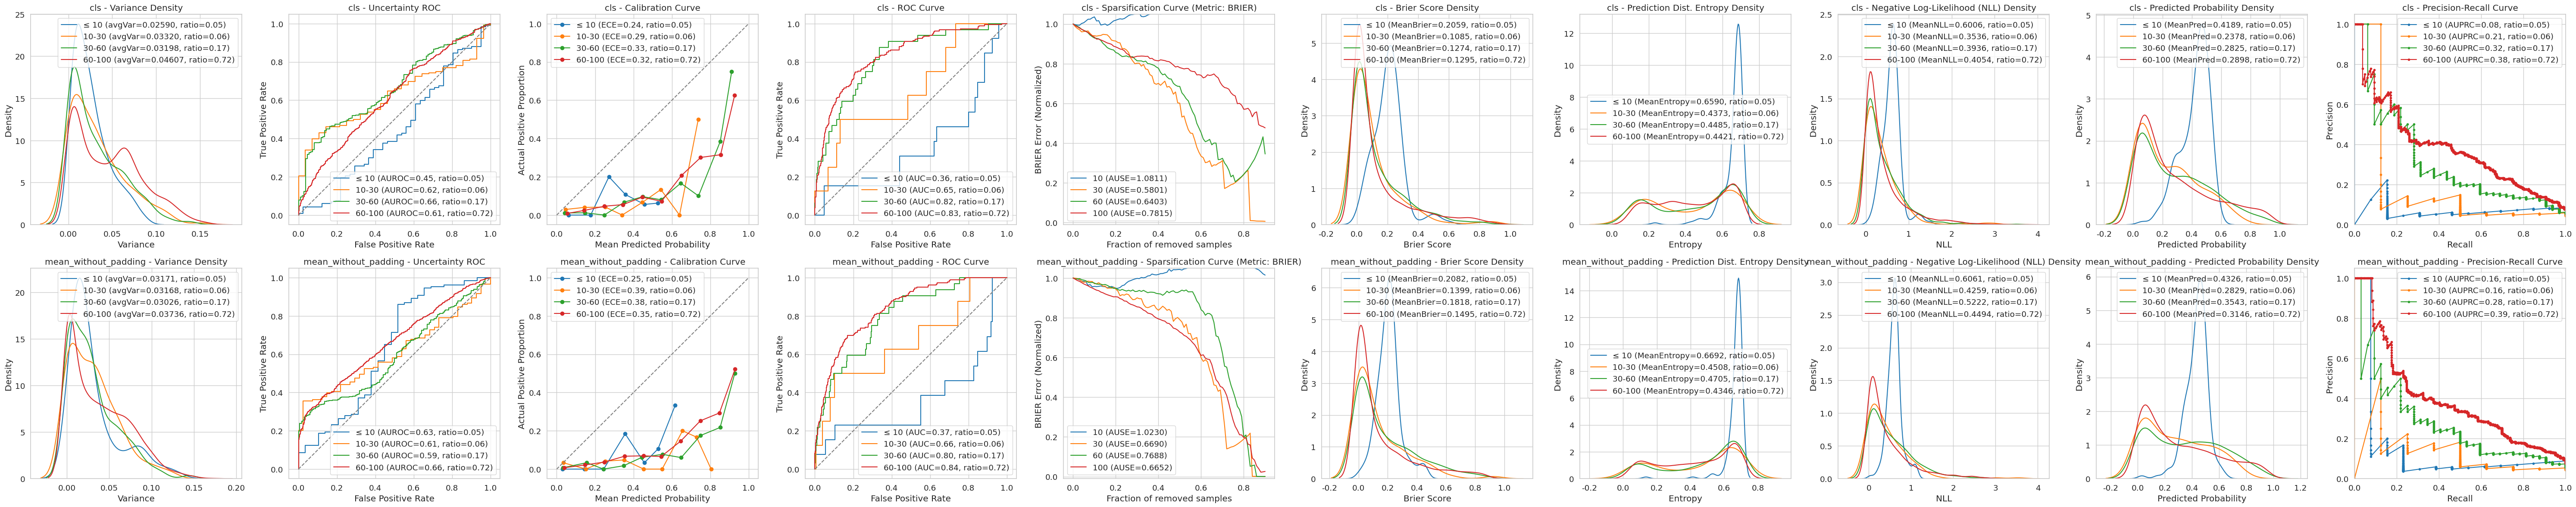

In [35]:
truncations=[10,30,60,100]
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations)+1)
data=model_result_show(
    res_set,
    y_val_int,
    sql,
    poolings,
    truncations,
    truncation_colors,
    metric='brier'
)


/tmp/ipykernel_634553/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_634553/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_634553/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
/tmp/ipykernel_634553/2474444826.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.i

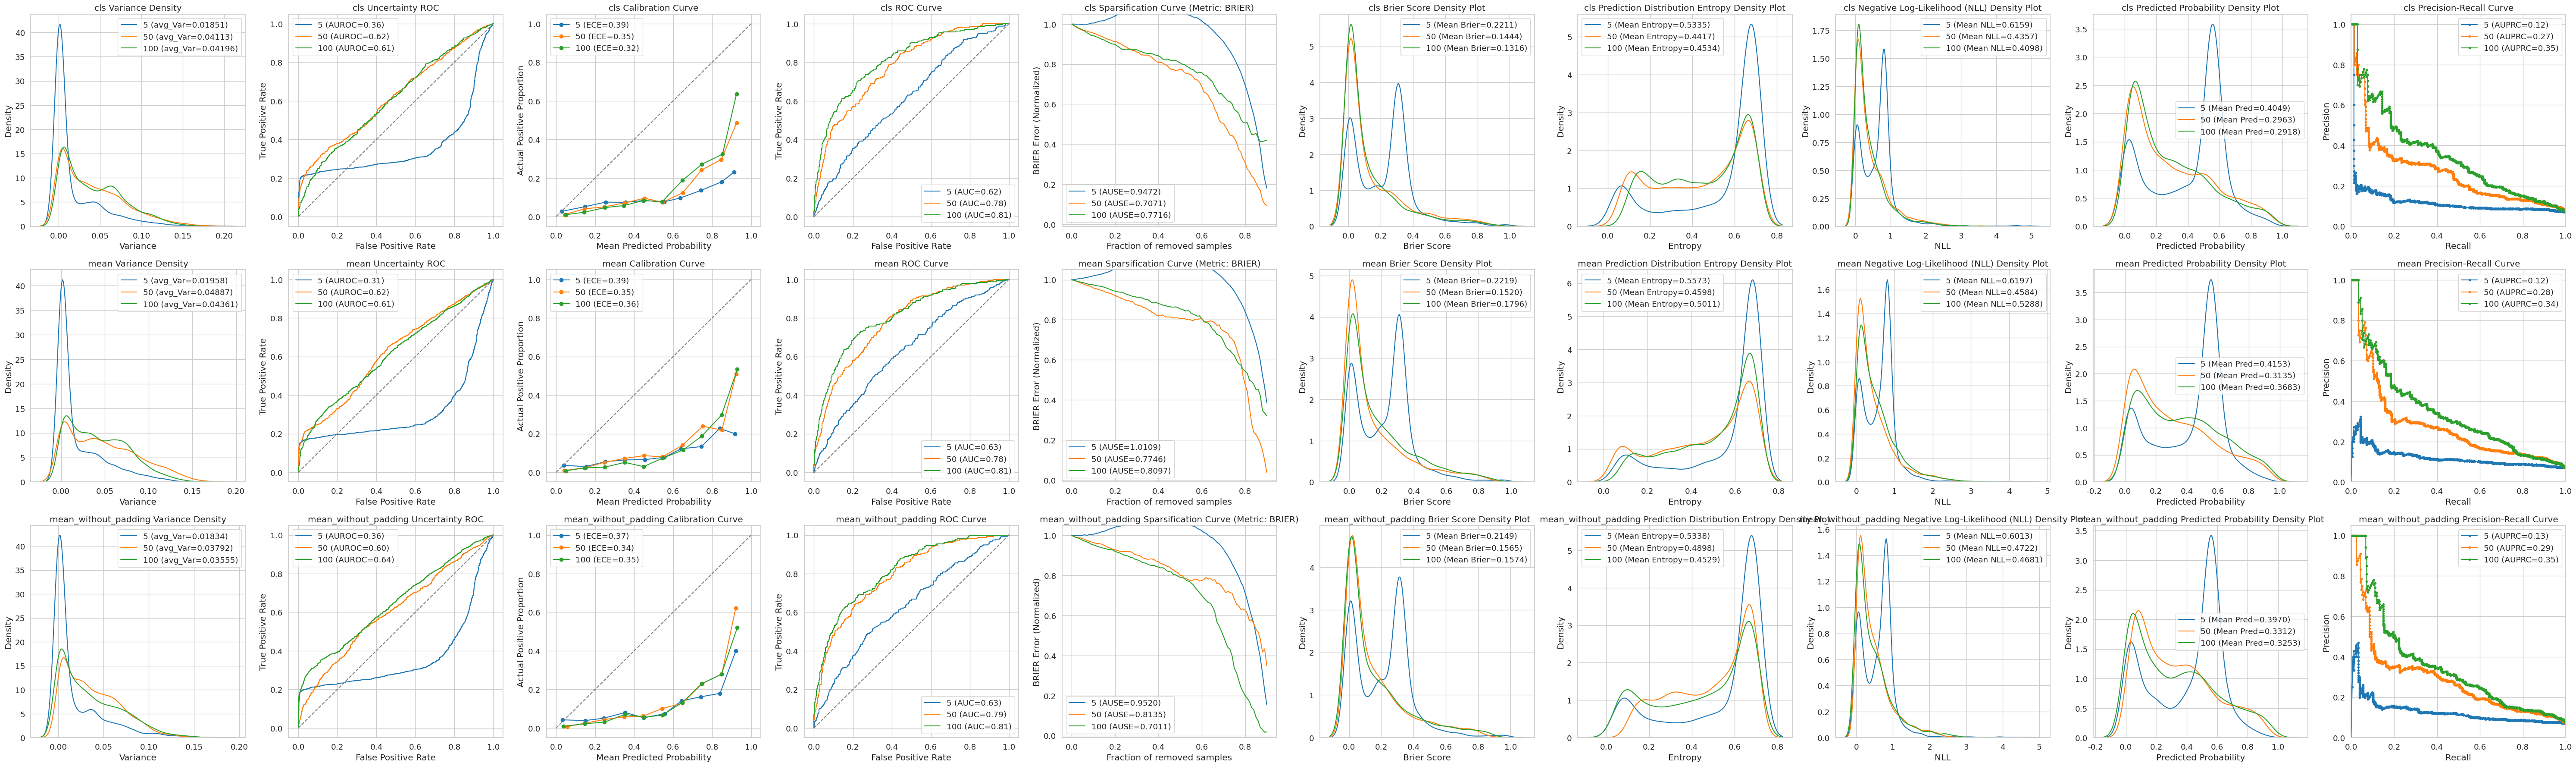

In [27]:
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations))
data=model_result_show(res_set,y_val_int,poolings,truncations,truncation_colors,metric="brier")


/tmp/ipykernel_706340/1492530582.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)
/tmp/ipykernel_706340/1492530582.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)
/tmp/ipykernel_706340/1492530582.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)
/tmp/ipykernel_706340/1492530582.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)
/tmp/ipykernel_706340/1492530582.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_lab

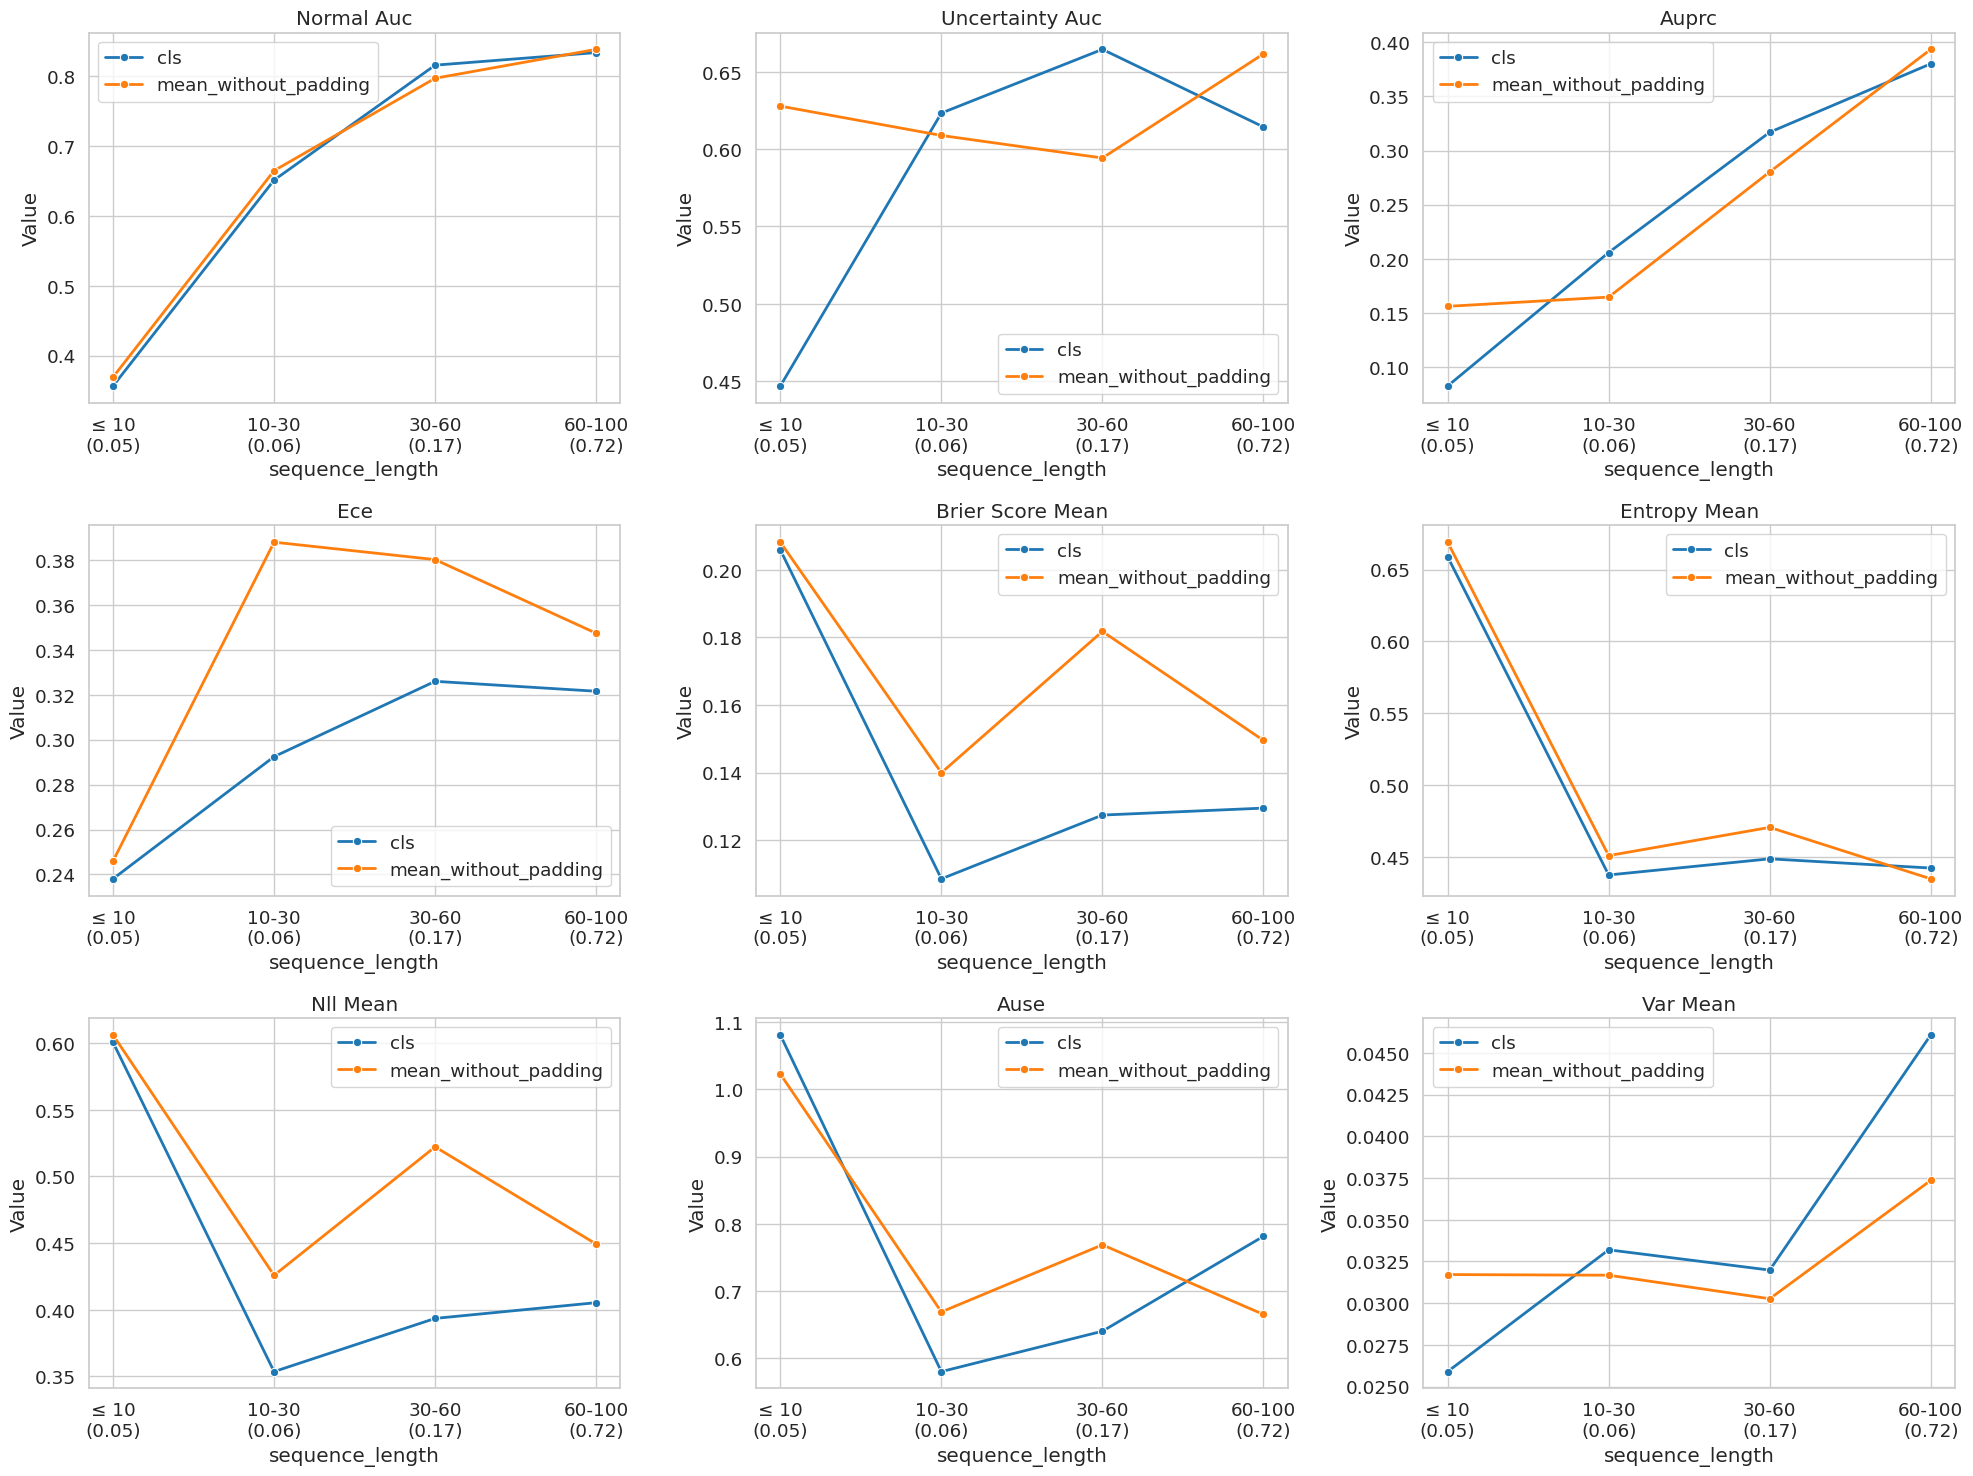

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_ratio_dict = df.groupby('truncation')['ratio'].first().to_dict()
metrics = df.columns.to_list()[3:10] + df.columns.to_list()[11:]
df_melted = df.melt(
    id_vars=['pooling', 'truncation'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(
            data=data_pooling,
            x='truncation',
            y='value',
            marker='o',
            label=pooling,
            color=color_dict[pooling],
            ax=ax,
            linewidth=2
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('sequence_length')
    ax.set_ylabel('Value')
    ax.legend()
    current_ticklabels = ax.get_xticklabels()
    new_labels = []
    for lbl in current_ticklabels:
        text = lbl.get_text()
        if text in truncation_ratio_dict:
            ratio_val = truncation_ratio_dict[text]
            new_label = f"{text}\n({ratio_val:.2f})"
        else:
            new_label = text
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
for j in range(len(unique_metrics), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


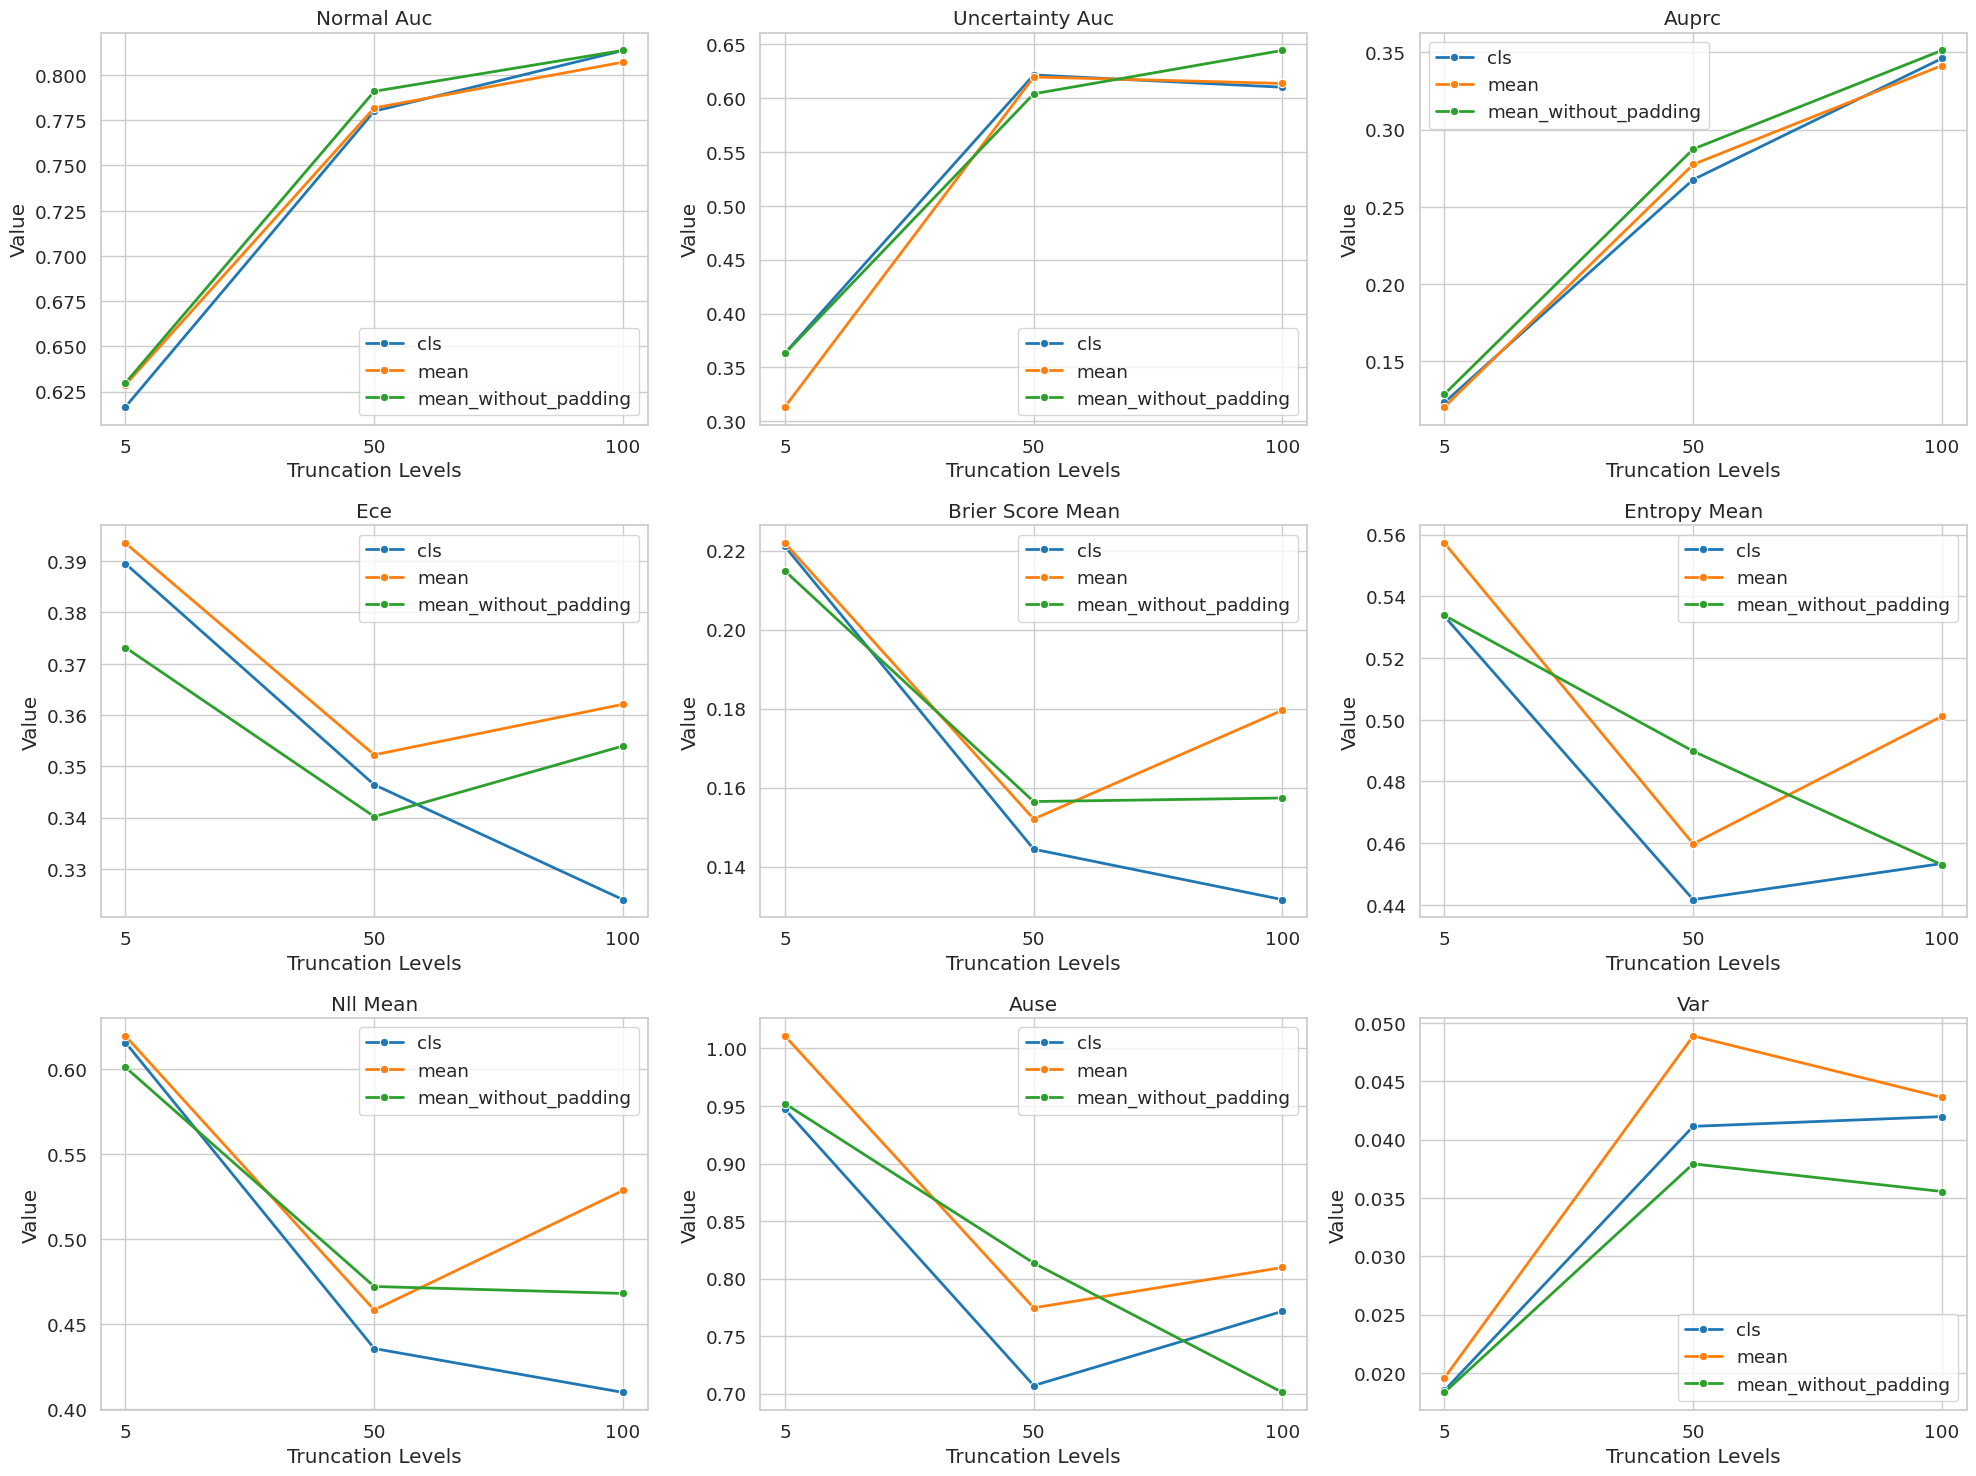

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_order = truncations
df['truncation'] = pd.Categorical(df['truncation'], categories=truncation_order, ordered=True)
metrics = ['normal_auc', 'uncertainty_auc', 'auprc', 'ece',
           'brier_score_mean', 'entropy_mean', 'nll_mean',
            'ause',"var"]
df_melted = df.melt(id_vars=['pooling', 'truncation'],
                    value_vars=metrics,
                    var_name='metric',
                    value_name='value')
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(data=data_pooling, x='truncation', y='value',
                     marker='o', label=pooling, color=color_dict[pooling], ax=ax, linewidth=2)
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('Truncation Levels')
    ax.set_ylabel('Value')
    ax.legend()
plt.tight_layout()
plt.show()
